# Introducción

Your goal is to predict the operating condition of a waterpoint for each record in the dataset. You are provided the following set of information about the waterpoints:

In [134]:
data = """id - Pump identifier
amount_tsh - Total static head (amount water available to waterpoint)
date_recorded - The date the row was entered
funder - Who funded the well
gps_height - Altitude of the well
installer - Organization that installed the well
longitude - GPS coordinate
latitude - GPS coordinate
wpt_name - Name of the waterpoint if there is one
num_private - Unknown
basin - Geographic water basin
subvillage - Geographic location
region - Geographic location
region_code - Geographic location (coded)
district_code - Geographic location (coded)
lga - Geographic location
ward - Geographic location
population - Population around the well
public_meeting - True/False
recorded_by - Group entering this row of data
scheme_management - Who operates the waterpoint
scheme_name - Who operates the waterpoint
permit - If the waterpoint is permitted
construction_year - Year the waterpoint was constructed
extraction_type - The kind of extraction the waterpoint uses
extraction_type_group - The kind of extraction the waterpoint uses
extraction_type_class - The kind of extraction the waterpoint uses
management - How the waterpoint is managed
management_group - How the waterpoint is managed
payment - What the water costs
payment_type - What the water costs
water_quality - The quality of the water
quality_group - The quality of the water
quantity - The quantity of water
quantity_group - The quantity of water
source - The source of the water
source_type - The source of the water
source_class - The source of the water
waterpoint_type - The kind of waterpoint
waterpoint_type_group - The kind of waterpoint
status_group - Descriptive value of pump status
tag - Numeric value of pump status"""

The labels in this dataset are simple. There are three possible values:

- functional (0): the waterpoint is operational and there are no repairs needed
- functional needs repair (1): the waterpoint is operational, but needs repairs
- non functional (2): the waterpoint is not operational

# Imports & Functions

In [69]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [269]:
def get_metrics(tags, predictions):
    print(f1_score(tags, predictions, average='macro'))
    print(accuracy_score(tags, predictions))
    print(confusion_matrix(tags, predictions))

def show_features_importance(model, features):
    importance = model.feature_importances_
    importance_dict = {}
    total = 0
    for v,i in sorted(zip(importance, features), reverse=False):
        total += v
        importance_dict[i] = v

    plt.figure(figsize=(10,len(features)))
    plt.barh(list(importance_dict.keys()), importance_dict.values(), color='g')
    plt.show()

def show_missing_unique(df, data=None):
    if data:
        return pd.DataFrame({'type':df.dtypes,
                  'missing':df.isnull().sum(),
                  '% missing':round(df.isnull().sum()*100/len(df),2),
                  'unique':[len(df[col].unique()) for col in df.columns],
                  '% unique':[round(len(df[col].unique())*100/len(df),2) for col in df.columns],
                  'description':[x.split(' - ')[1] for x in data.split('\n')]}
                ).style.background_gradient(cmap='viridis')
    return pd.DataFrame({'type':df.dtypes,
                  'missing':df.isnull().sum(),
                  '% missing':round(df.isnull().sum()*100/len(df),2),
                  'unique':[len(df[col].unique()) for col in df.columns],
                  '% unique':[round(len(df[col].unique())*100/len(df),2) for col in df.columns]}
                ).style.background_gradient(cmap='viridis')

# Carga de datos y Preprocesado

In [408]:
df = pd.merge(pd.read_csv('data/training.csv'), pd.read_csv('data/labels.csv'),
              left_on='id', right_on='id')
test = pd.read_csv('data/test.csv')

df['tag'] = LabelEncoder().fit_transform(df['status_group'])

In [298]:
show_missing_unique(df, data)

,type,missing,% missing,unique,% unique,description
id,int64,0,0.000000,59400,100.000000,Pump identifier
amount_tsh,float64,0,0.000000,98,0.160000,Total static head (amount water available to waterpoint)
date_recorded,object,0,0.000000,356,0.600000,The date the row was entered
funder,object,3635,6.120000,1898,3.200000,Who funded the well
gps_height,int64,0,0.000000,2428,4.090000,Altitude of the well
installer,object,3655,6.150000,2146,3.610000,Organization that installed the well
longitude,float64,0,0.000000,57516,96.830000,GPS coordinate
latitude,float64,0,0.000000,57517,96.830000,GPS coordinate
wpt_name,object,0,0.000000,37400,62.960000,Name of the waterpoint if there is one
num_private,int64,0,0.000000,65,0.110000,Unknown


- Decidimos eliminar la variable `scheme_name` por tener casi la mitad de valores perdidos.
- Eliminamos también la variable `recorded_by` por tener un único valor (no aporta información)
- Eliminamos la variable `date_recorded` puesto que no aporta información relevante.

- Modificamos la variable `public_meeting` y `permit` a numérica 0/1

In [409]:
df.drop(columns=['scheme_name','recorded_by','date_recorded'], inplace=True)
df[["public_meeting",'permit']] = df[["public_meeting",
                                      'permit']].applymap(lambda x: int(x) if x is not np.nan else -1)

## Variables Categóricas

In [411]:
for col in df.select_dtypes(include='O').columns:
    print(col, df[col].unique())
    
(df.select_dtypes(include=['O']) == 'unknown').sum(axis=0)

funder ['Roman' 'Grumeti' 'Lottery Club' ... 'Dina' 'Brown' 'Samlo']
installer ['Roman' 'GRUMETI' 'World vision' ... 'Dina' 'brown' 'SELEPTA']
wpt_name ['none' 'Zahanati' 'Kwa Mahundi' ... 'Kwa Yahona Kuvala' 'Mshoro'
 'Kwa Mzee Lugawa']
basin ['Lake Nyasa' 'Lake Victoria' 'Pangani' 'Ruvuma / Southern Coast'
 'Internal' 'Lake Tanganyika' 'Wami / Ruvu' 'Rufiji' 'Lake Rukwa']
subvillage ['Mnyusi B' 'Nyamara' 'Majengo' ... 'Itete B' 'Maore Kati' 'Kikatanyemba']
region ['Iringa' 'Mara' 'Manyara' 'Mtwara' 'Kagera' 'Tanga' 'Shinyanga' 'Tabora'
 'Pwani' 'Ruvuma' 'Kilimanjaro' 'Rukwa' 'Mwanza' 'Kigoma' 'Lindi' 'Dodoma'
 'Arusha' 'Mbeya' 'Singida' 'Morogoro' 'Dar es Salaam']
lga ['Ludewa' 'Serengeti' 'Simanjiro' 'Nanyumbu' 'Karagwe' 'Mkinga'
 'Shinyanga Rural' 'Kahama' 'Tabora Urban' 'Mkuranga' 'Namtumbo' 'Maswa'
 'Siha' 'Meatu' 'Sumbawanga Rural' 'Njombe' 'Ukerewe' 'Bariadi' 'Same'
 'Kigoma Rural' 'Moshi Rural' 'Lindi Rural' 'Rombo' 'Chamwino' 'Bagamoyo'
 'Mafia' 'Arusha Rural' 'Kyela' 'Kondoa

funder                      0
installer                   1
wpt_name                    0
basin                       0
subvillage                  0
region                      0
lga                         0
ward                        0
scheme_management           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                561
management_group          561
payment                  8157
payment_type             8157
water_quality            1876
quality_group            1876
quantity                  789
quantity_group            789
source                     66
source_type                 0
source_class              278
waterpoint_type             0
waterpoint_type_group       0
status_group                0
dtype: int64

In [428]:
show_missing_unique(df)

,type,missing,% missing,unique,% unique
id,int64,0,0.000000,59400,100.000000
amount_tsh,float64,0,0.000000,98,0.160000
funder,object,0,0.000000,1898,3.200000
gps_height,int64,0,0.000000,2428,4.090000
installer,object,0,0.000000,2145,3.610000
longitude,float64,0,0.000000,57516,96.830000
latitude,float64,0,0.000000,57517,96.830000
wpt_name,object,0,0.000000,37400,62.960000
num_private,int64,0,0.000000,65,0.110000
basin,object,0,0.000000,9,0.020000


In [431]:
sorted(df['source'].unique())

['dam',
 'hand dtw',
 'lake',
 'machine dbh',
 'other',
 'rainwater harvesting',
 'river',
 'shallow well',
 'spring',
 'unknown']

Se observa que hay valores que deberían ser idénticos pero son diferentes (ej. 'GRUMETI' y 'Grumeti'). Además, hay valores 'unknown' que deberían representarse como NAs

In [373]:
show_missing_unique(df)

,type,missing,% missing,unique,% unique
id,int64,0,0.000000,59400,100.000000
amount_tsh,float64,0,0.000000,98,0.160000
funder,object,0,0.000000,1898,3.200000
gps_height,int64,0,0.000000,2428,4.090000
installer,object,0,0.000000,2145,3.610000
longitude,float64,0,0.000000,57516,96.830000
latitude,float64,0,0.000000,57517,96.830000
wpt_name,object,0,0.000000,37400,62.960000
num_private,int64,0,0.000000,65,0.110000
basin,object,0,0.000000,9,0.020000


## Variables Numéricas

In [325]:
show_missing_unique(df.select_dtypes(include=numerics))

,type,missing,% missing,unique,% unique
id,int64,0,0.000000,59400,100.000000
amount_tsh,float64,0,0.000000,98,0.160000
gps_height,int64,0,0.000000,2428,4.090000
longitude,float64,0,0.000000,57516,96.830000
latitude,float64,0,0.000000,57517,96.830000
num_private,int64,0,0.000000,65,0.110000
region_code,int64,0,0.000000,27,0.050000
district_code,int64,0,0.000000,20,0.030000
population,int64,0,0.000000,1049,1.770000
public_meeting,int64,0,0.000000,2,0.000000


Observamos que las variables numéricas no tienen valores perdidos. Vamos a analizarlas

In [189]:
_ = [print(col,len(df[df[col]==0])) for col in df.select_dtypes(include=numerics)]

id 1
amount_tsh 41639
gps_height 20438
longitude 1812
latitude 0
num_private 58643
region_code 0
district_code 23
population 21381
construction_year 20709
tag 32259


Observamos que hay muchos valores 0 para ciertas columnas. Esto podemos entenderlo como valores perdidos. Por ejemplo, no existe el `construction_year` igual a 0

In [91]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df.select_dtypes(include=numerics).describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,tag
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475,0.841162
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547,0.949794
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000,0.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000,2.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,2.000000


(array([   66.,  3629., 17133., 13558.,  4600.,  6248.,  9076.,  3951.,
         1139.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 9 artists>)

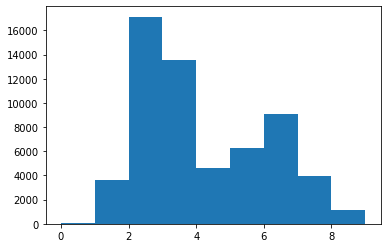

In [232]:
plt.hist((df == 0).sum(axis=1), bins=9)

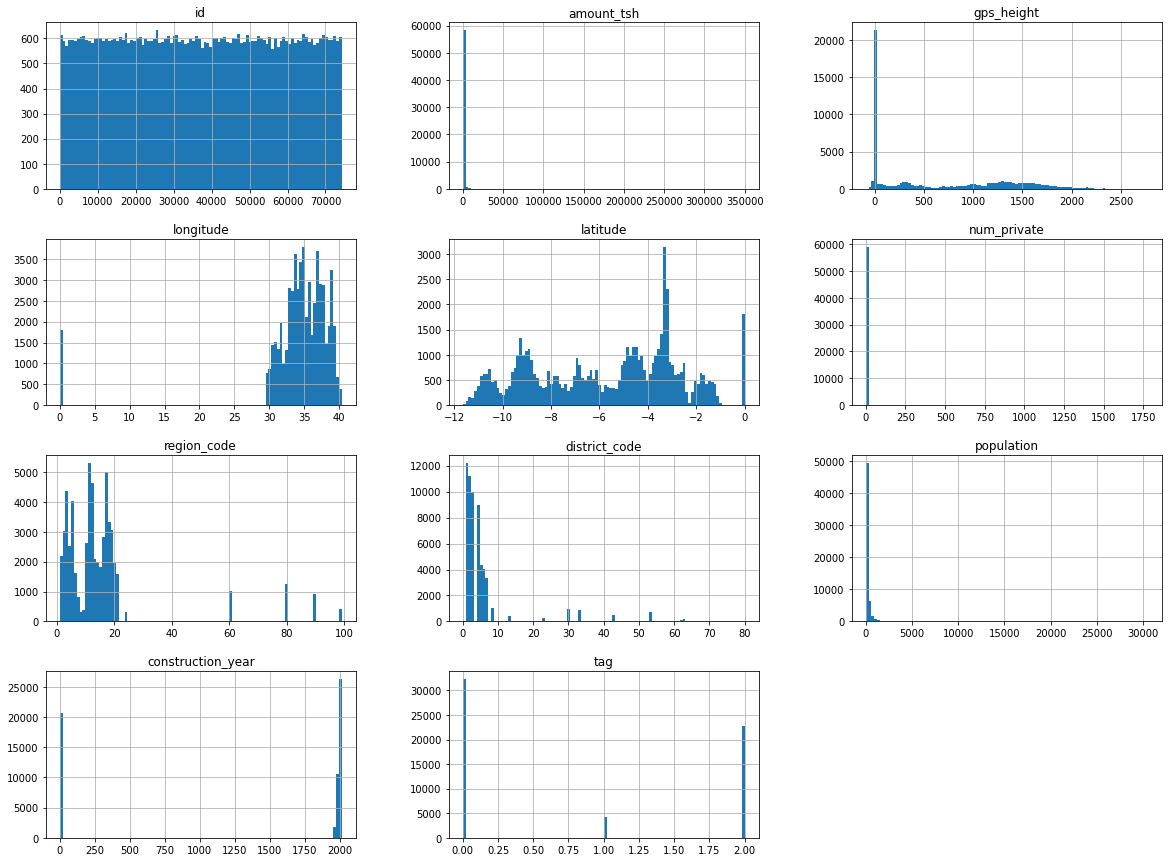

In [212]:
_ = df.hist(bins = 100, figsize=(20,15))

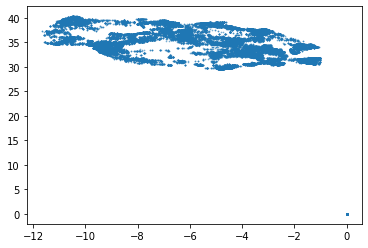

In [225]:
_ = plt.scatter(df['latitude'], df['longitude'], alpha=0.5, s=0.5)

<AxesSubplot:>

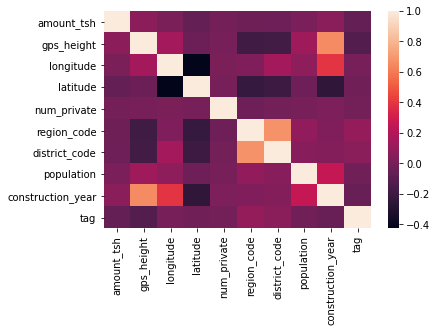

In [180]:
var_corr = df.select_dtypes(include=numerics).iloc[:,1:].corr()
sns.heatmap(var_corr, xticklabels=var_corr.columns, yticklabels=var_corr.columns)

# Entrenamiento de Modelos

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:-2].select_dtypes(include=numerics),
                                                    df['tag'], test_size=0.2, random_state=42)

In [41]:
rf = RandomForestClassifier(n_jobs=-1).fit(X_train, y_train)

In [42]:
preds = rf.predict(X_test)

In [43]:
get_metrics(y_test, preds)

0.6053261671293276
0.7239057239057239
[[5261  165 1031]
 [ 443  229  179]
 [1351  111 3110]]


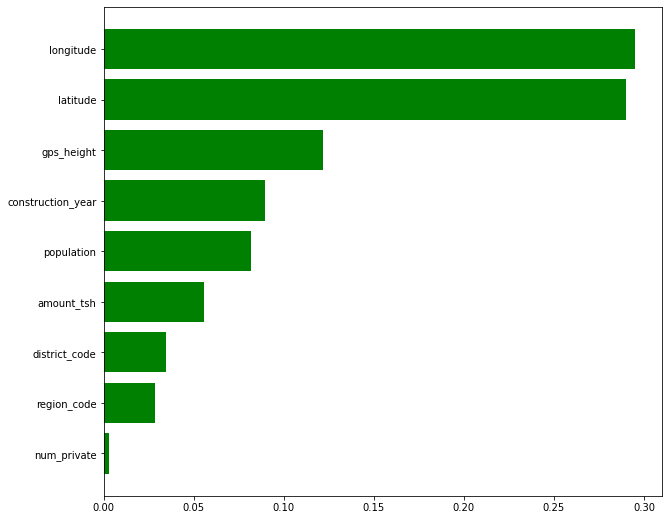

In [47]:
show_features_importance(rf, X_test.columns)

In [117]:
preds_test = rf.predict(test.iloc[:,1:].select_dtypes(include=numerics))

In [118]:
[round(x*100/len(preds_test),2) for x in np.unique(preds_test, return_counts=True)[1]]

[59.62, 4.25, 36.13]